# HMDA Data: Summ. Stats., Visualizations, and OLS Reg. Analysis

## Exploratory Analysis with ```Pandas```, and statistical libraries for OLS Regression.
This notebook explores the Home Mortgage Disclosure Act (HMDA) data for one year -- 2017. Note that as of July 12, 2019, HMDA data is publically available for 2007 - 2017.
https://www.consumerfinance.gov/data-research/hmda/explore

In this notebook, we utilize ```pandas``` to visualize and clean data from the an AWS PostgreSQL Relational Database System. Afterwards it is also recommended that you complete the "additional_wrangling_challenge" notebook, which expands on these skills and is included in this course's repository.

**A README is under development to keep track of notes not included here and learning materials.** In addition, you may also find these resources helpful:  
https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-learn-data-science-python-scratch-2/  
https://chrisalbon.com/python/data_wrangling/pandas_dataframe_descriptive_stats/
https://lectures.quantecon.org/py/ols.html

*There are many learning sources and prior work around similar topics: We draw inspiration from past Cohorts as well as learning materials from peer sources such as Kaggle and Towards Data Science*

---


## Importing Libraries and Loading the Data


First, we need to import all the libraries we are going to utilize throughout this notebook. We import everything at the very top of this notebook for order and best practice.

In [145]:
# Importing Libraries.

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import os
import psycopg2
import pandas.io.sql as psql
import sqlalchemy
from sqlalchemy import create_engine


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

*-----*
 
Second, we establish the connection to the AWS PostgreSQL Relational Database System.

In [98]:
# Connecting to AWS PostgreSQL RDS.

engine_hmda_2017 = psycopg2.connect(
    database="paddle_loan_canoe",
    user="reporting_user",
    password="team_loan_canoe2019",
    host="aws-pgsql-loan-canoe.cr3nrpkvgwaj.us-east-2.rds.amazonaws.com",
    port='5432'
)


 *Note: A better way to do this is to define variables and put it into a function so you can easily call a specified engine, as seen below:*

In [99]:
# Postgres username, password, and database name.
postgres_host = 'aws-pgsql-loan-canoe.cr3nrpkvgwaj.us-east-2.rds.amazonaws.com'  
postgres_port = '5432' 
postgres_username = 'reporting_user' 
postgres_password = 'team_loan_canoe2019'
postgres_dbname = "paddle_loan_canoe"
postgres_str = ('postgresql://{username}:{password}@{host}:{port}/{dbname}'
                .format(username = postgres_username,
                        password = postgres_password,
                        host = postgres_host,
                        port = postgres_port,
                        dbname = postgres_dbname)
               )


# Creating the connection.
cnx = create_engine(postgres_str)

---

## Using Pandas:  Exploring the Data

In [130]:
#  Reading the HMDA 2017 dataset; join population and education datasets appropriately for 2017 
#  for the first 50,000 rows -- as a dataframe using pandas: df.

df = pd.read_sql_query ('''SELECT 
                              --> a. main: casting a few key MORTGAGE data fields:
                                   CAST(us17.action_taken_name As varchar(56)) As outcome, us17.as_of_year As year,
                                   CAST(denial_reason_name_1 As varchar(56)) dn_reason1 , CAST(us17.agency_name As varchar(56)) As agency,
                                   CAST(us17.state_name As varchar(28)) As state,         CAST(us17.county_name As varchar(56)) As county,
                                   CAST(us17.loan_type_name As varchar(56)) As ln_type,   CAST(us17.loan_purpose_name As varchar(56)) As ln_purp, 
                                   us17.loan_amount_000s As ln_amt_000s, us17.hud_median_family_income As hud_med_fm_inc, population as pop,

                                       --two embedded fuctions and one CASE below: assigns hierarchy in CASE, and converts to num in two steps
                                   CAST ( CAST ( CASE
                                                     WHEN us17.rate_spread = '' Then '0'
                                                     ELSE us17.rate_spread
                                                 END As varchar(5)
                                               ) As numeric
                                        )
                                   As rt_spread,
                              --*
                              --> b. macro-econ: casting and joining a few key EDUCATION data fields:
                                   CAST(educ17."Perc_adults w_less than a HS diploma_2013-17" As int)  As prc_blw_HS__2013_17_5yrAvg,
                                   CAST(educ17."Perc_adults w_ HS diploma only_2013-17" As int)        As prc_HS__2013_17_5yrAvg,
                                   CAST(educ17."Perc_adults w_BA deg or higher_2013-17" As int)        As prc_BA_plus__2013_17_5yrAvg,
                              --*
                              --> c. macro-econ: casting and joining a few key POPULATION data fields:
                                   CAST(pop17.r_birth_2017 AS INT)                                     As r_birth_2017,
                                   CAST(pop17.r_international_mig_2017 AS INT)                         As r_intl_mig_2017,
                                   CAST(pop17.r_natural_inc_2017 AS INT)                               As r_natural_inc_2017
                              --*
                           FROM usa_mortgage_market.hmda_lar__2017 us17 
                           LEFT OUTER JOIN v__macro_economic_indicators.education__acs_1970_to_2017_5yravgs educ17 
                                   ON us17.county_name = educ17."Area name"
                           LEFT OUTER JOIN v__macro_economic_indicators.populationestimates__usda_ers_2010_to_2018 pop17
                                   ON us17.county_name = pop17.area_name
                           LIMIT 100000''', cnx)

# Using pandas to view the first 5 rows (NB: why does it start at 0?).
df.head(5)

,outcome,year,dn_reason1,agency,state,county,ln_type,ln_purp,ln_amt_000s,hud_med_fm_inc,pop,rt_spread,prc_blw_hs__2013_17_5yravg,prc_hs__2013_17_5yravg,prc_ba_plus__2013_17_5yravg,r_birth_2017,r_intl_mig_2017,r_natural_inc_2017
0,File closed for incompleteness,2017,,Department of Housing and Urban Development,Connecticut,Middlesex County,Conventional,Refinancing,255,90200,4863,0.0,12.0,33.0,22.0,9.0,0.0,-6.0
1,File closed for incompleteness,2017,,Department of Housing and Urban Development,Connecticut,Middlesex County,Conventional,Refinancing,255,90200,4863,0.0,11.0,26.0,42.0,9.0,0.0,-6.0
2,File closed for incompleteness,2017,,Department of Housing and Urban Development,Connecticut,Middlesex County,Conventional,Refinancing,255,90200,4863,0.0,7.0,20.0,54.0,9.0,0.0,-6.0
3,File closed for incompleteness,2017,,Department of Housing and Urban Development,Connecticut,Middlesex County,Conventional,Refinancing,255,90200,4863,0.0,6.0,27.0,41.0,9.0,0.0,-6.0
4,Application withdrawn by applicant,2017,,Federal Deposit Insurance Corporation,Pennsylvania,Delaware County,Conventional,Refinancing,234,57400,3968,0.0,7.0,31.0,38.0,10.0,0.0,-4.0


*Note: We can also easily use Pandas functionality to perform the joins in the SQL script being read above. See Pandas Cheat Sheet:* 
*https://pandas.pydata.org/*

In [102]:
# Using pandas to generate the summary statistics on the data.

df.info()# getting info first.

print(' ')
print('------------------------------------------')
print(' ')

df.describe(include = 'all')# next, top down describe the data; there are specific stats functions you can use with pandas. 
# ==> good tutorial: https://www.tutorialspoint.com/python_pandas/python_pandas_descriptive_statistics.htm.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
outcome                        100000 non-null object
year                           100000 non-null int64
dn_reason1                     100000 non-null object
agency                         100000 non-null object
state                          100000 non-null object
county                         100000 non-null object
ln_type                        100000 non-null object
ln_purp                        100000 non-null object
ln_amt_000s                    100000 non-null int64
hud_med_fm_inc                 100000 non-null int64
pop                            100000 non-null int64
rt_spread                      100000 non-null float64
prc_blw_hs__2013_17_5yravg     100000 non-null int64
prc_hs__2013_17_5yravg         100000 non-null int64
prc_ba_plus__2013_17_5yravg    100000 non-null int64
r_birth_2017                   98797 non-null float64
r_intl_mig_2017                9

,outcome,year,dn_reason1,agency,state,county,ln_type,ln_purp,ln_amt_000s,hud_med_fm_inc,pop,rt_spread,prc_blw_hs__2013_17_5yravg,prc_hs__2013_17_5yravg,prc_ba_plus__2013_17_5yravg,r_birth_2017,r_intl_mig_2017,r_natural_inc_2017
count,100000,100000.0,100000,100000,100000,100000,100000,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,98797.000000,98797.000000,98797.000000
unique,6,NaN,9,6,35,235,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Loan originated,NaN,,Department of Housing and Urban Development,Ohio,Washington County,Conventional,Home purchase,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,49868,NaN,84450,45097,19796,19440,70366,56920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,175.993870,69279.843000,5004.372410,0.117506,12.998030,33.960930,22.777190,10.884359,0.806057,-0.043129
std,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,186.397681,13218.603735,2306.846344,0.718339,5.457908,7.245256,10.407152,1.873229,1.535182,3.091829
min,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,44500.000000,120.000000,0.000000,1.000000,12.000000,8.000000,4.000000,-1.000000,-10.000000
25%,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,97.000000,60500.000000,2843.000000,0.000000,9.000000,30.000000,16.000000,10.000000,0.000000,-2.000000
50%,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,150.000000,73900.000000,4745.000000,0.000000,12.000000,34.000000,20.000000,11.000000,0.000000,0.000000
75%,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,219.000000,74500.000000,6441.000000,0.000000,17.000000,39.000000,28.000000,12.000000,1.000000,2.000000


In [146]:
# Using pandas to generate the number of unique values for loan outcome, grouped by the agency deciding the loan outcome.

df.groupby('agency')['outcome'].value_counts()

agency                                       outcome                                    
Consumer Financial Protection Bureau         Loan originated                                10679
                                             Loan purchased by the institution               7059
                                             Application denied by financial institution     6239
                                             Application withdrawn by applicant              2355
                                             Application approved but not accepted            981
                                             File closed for incompleteness                   328
Department of Housing and Urban Development  Loan originated                                22071
                                             Application denied by financial institution     6575
                                             Application withdrawn by applicant              6472
                             

---

## Using Pandas: Visualizing the Data


First, we generate a simple histogram of the ```Loan Amount``` data, setting the ```bins = 50```, so we can see the distrubtion in somewhat finer detail.

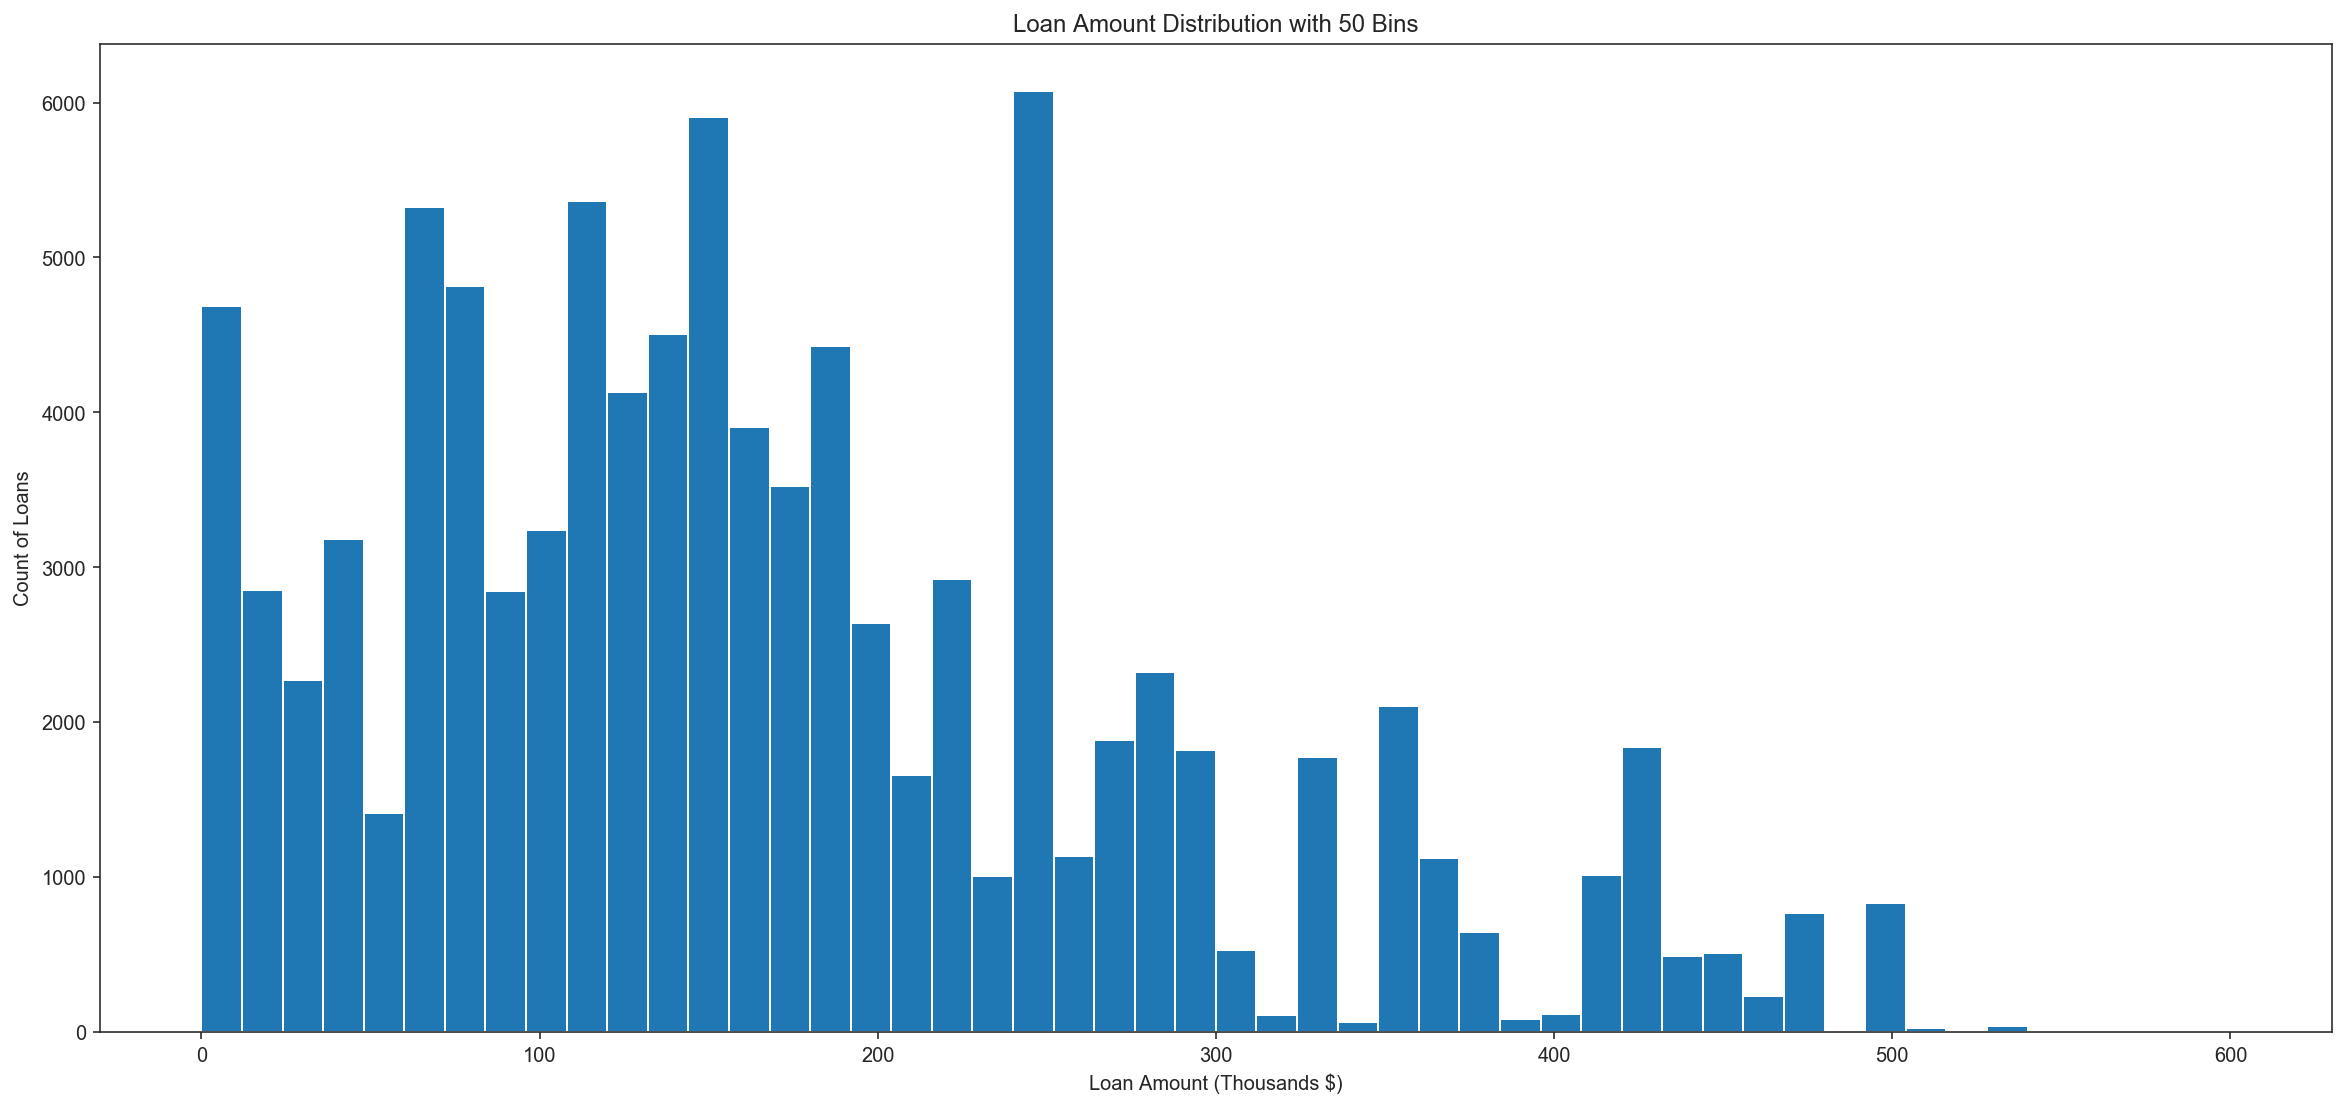

 
---
 


In [151]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(212)
ax.hist(df['ln_amt_000s'], bins=50, range=[0, 600]) # default --> range=(df['Fare'].min(),df['Fare'].max()).
plt.title('Loan Amount Distribution with 50 Bins')
plt.xlabel('Loan Amount (Thousands $)')
plt.ylabel('Count of Loans')
plt.show()

print(' ')
print('---')
print(' ')

Next, we employe ```seaborn``` to create distribution plots.

 
Loan Application Outcome: Scatter Plot of Loan Amounts vs. Household Median Income


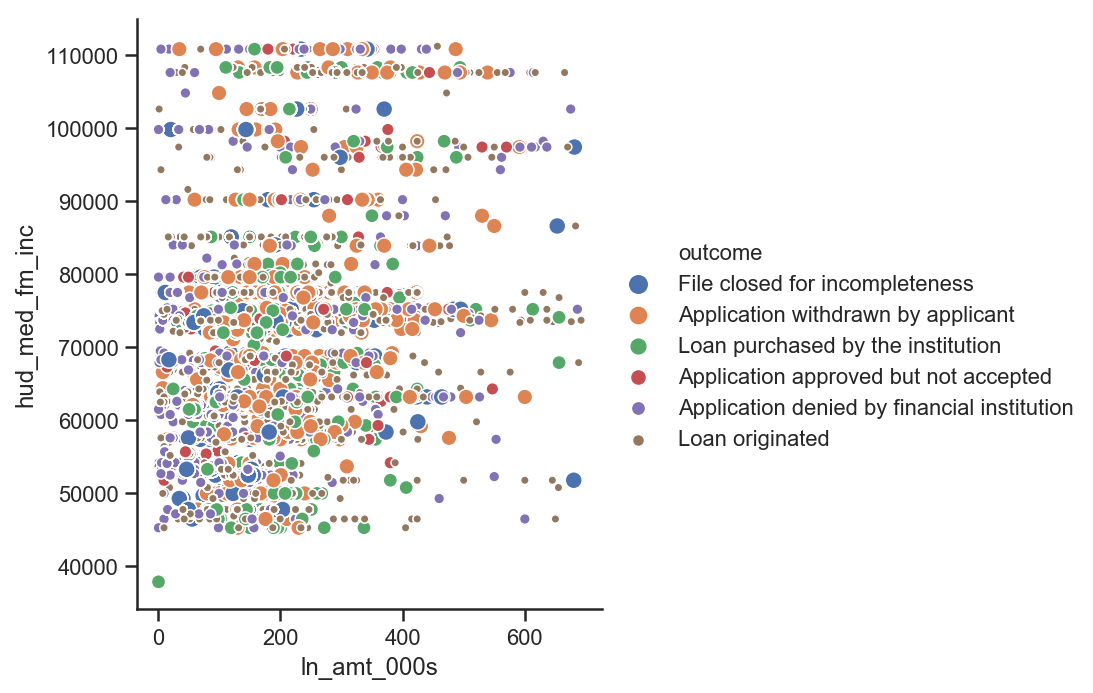

In [156]:
# All in one scatter plot, colored by loan outcome.

    # --> Drawing a single facet to use the FacetGrid legend placement.
sns.set(style = 'ticks')
df2 = (df[df.ln_amt_000s < 700])
g = sns.relplot(x = 'ln_amt_000s', y = 'hud_med_fm_inc', hue = 'outcome', 
                size = 'outcome', data = df2)
print(' ')
print('Loan Application Outcome: Scatter Plot of Loan Amounts vs. Household Median Income')

*Note: ```sns.relplot``` is a "Figure-level interface for drawing relational plots onto a FacetGrid". See API: https://seaborn.pydata.org/generated/seaborn.relplot.html.*

 
Loan Application Outcome: Scatter Plot of Loan Amounts vs. Household Median Income, Grouped by Loan Purpose


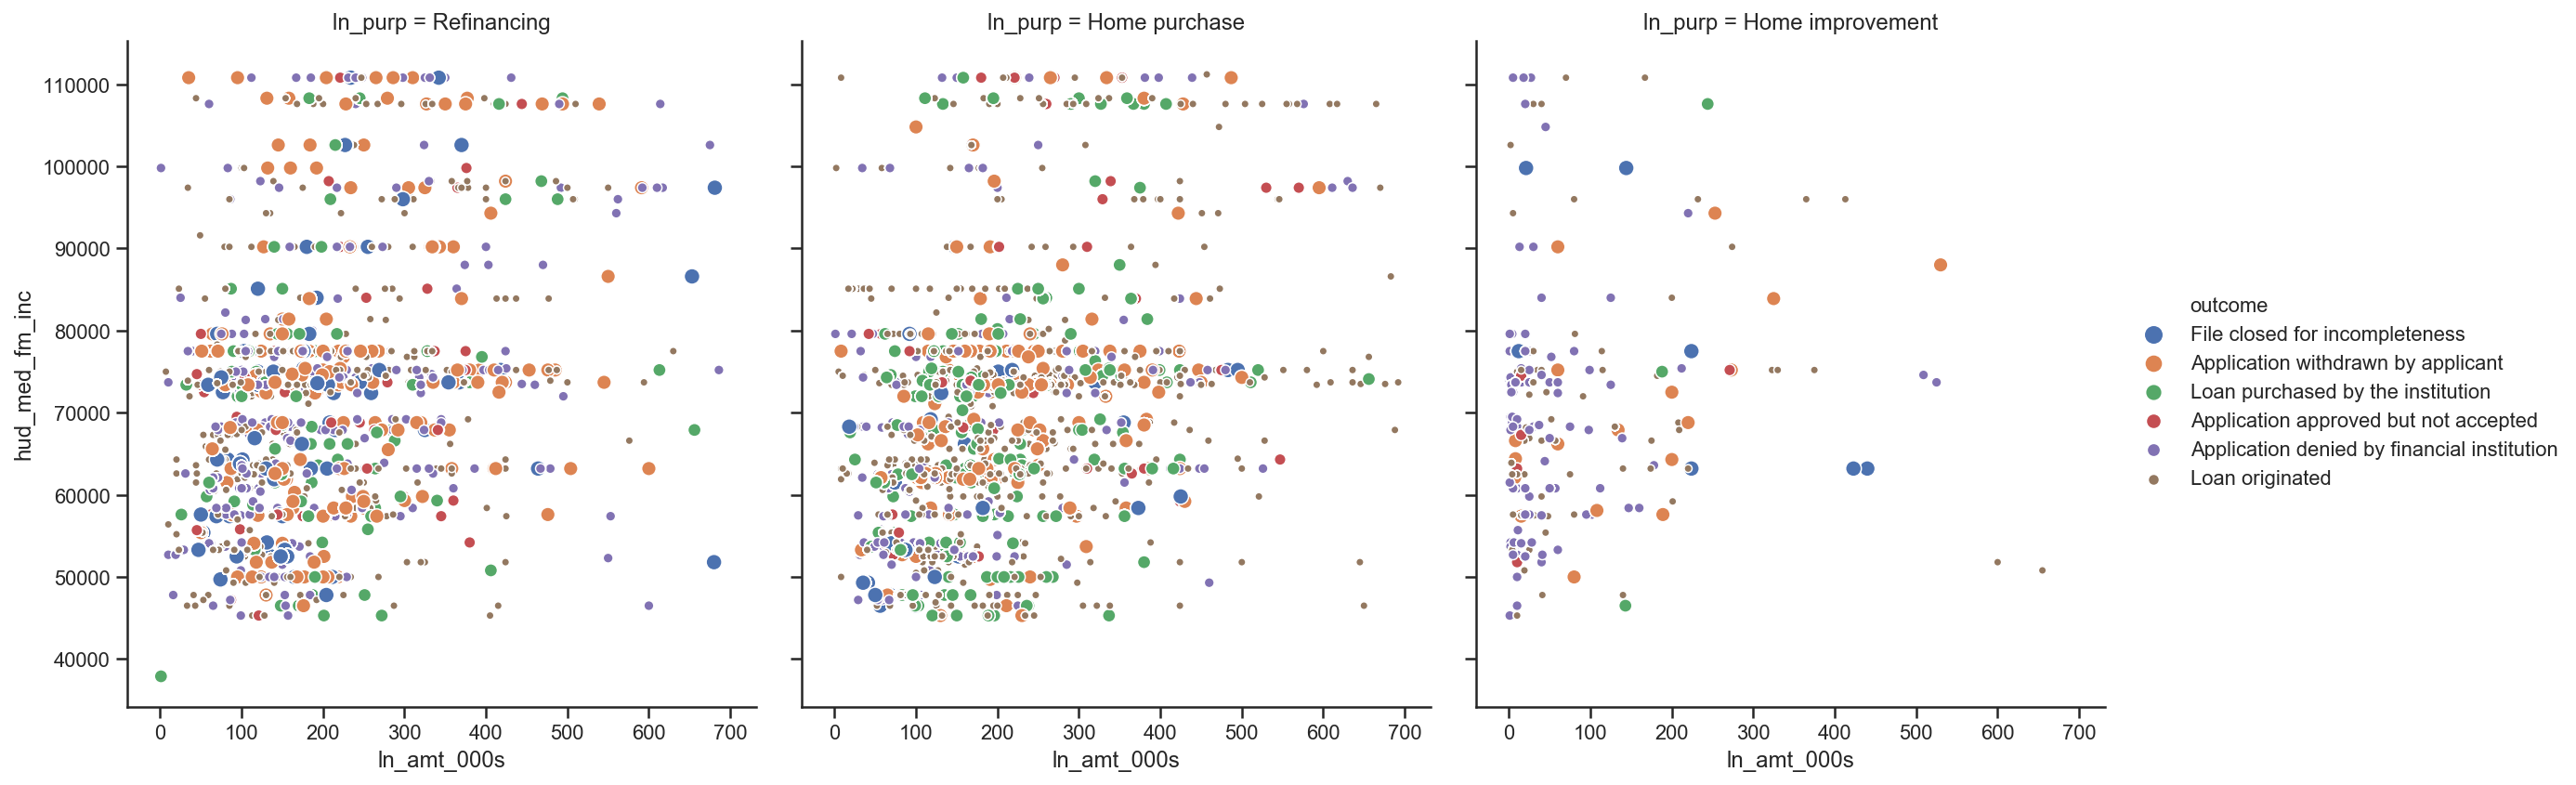

In [167]:
# Grouped by Loan Purpose.

    # --> Drawing scatter plots for multiple column with another variable.
df2 = df[df.ln_amt_000s < 700]
g = sns.relplot(x = 'ln_amt_000s', y = 'hud_med_fm_inc', col = 'ln_purp', hue = 'outcome', 
                size = 'outcome', height = 6, aspect = 0.9, legend = 'brief', data = df2)
print(' ')
print('Loan Application Outcome: Scatter Plot of Loan Amounts vs. Household Median Income, Grouped by Loan Purpose')

 
Loan Application Outcome: Scatter Plot of Loan Amounts vs. Household Median Income, Grouped by Loan Purpose and Loan Type


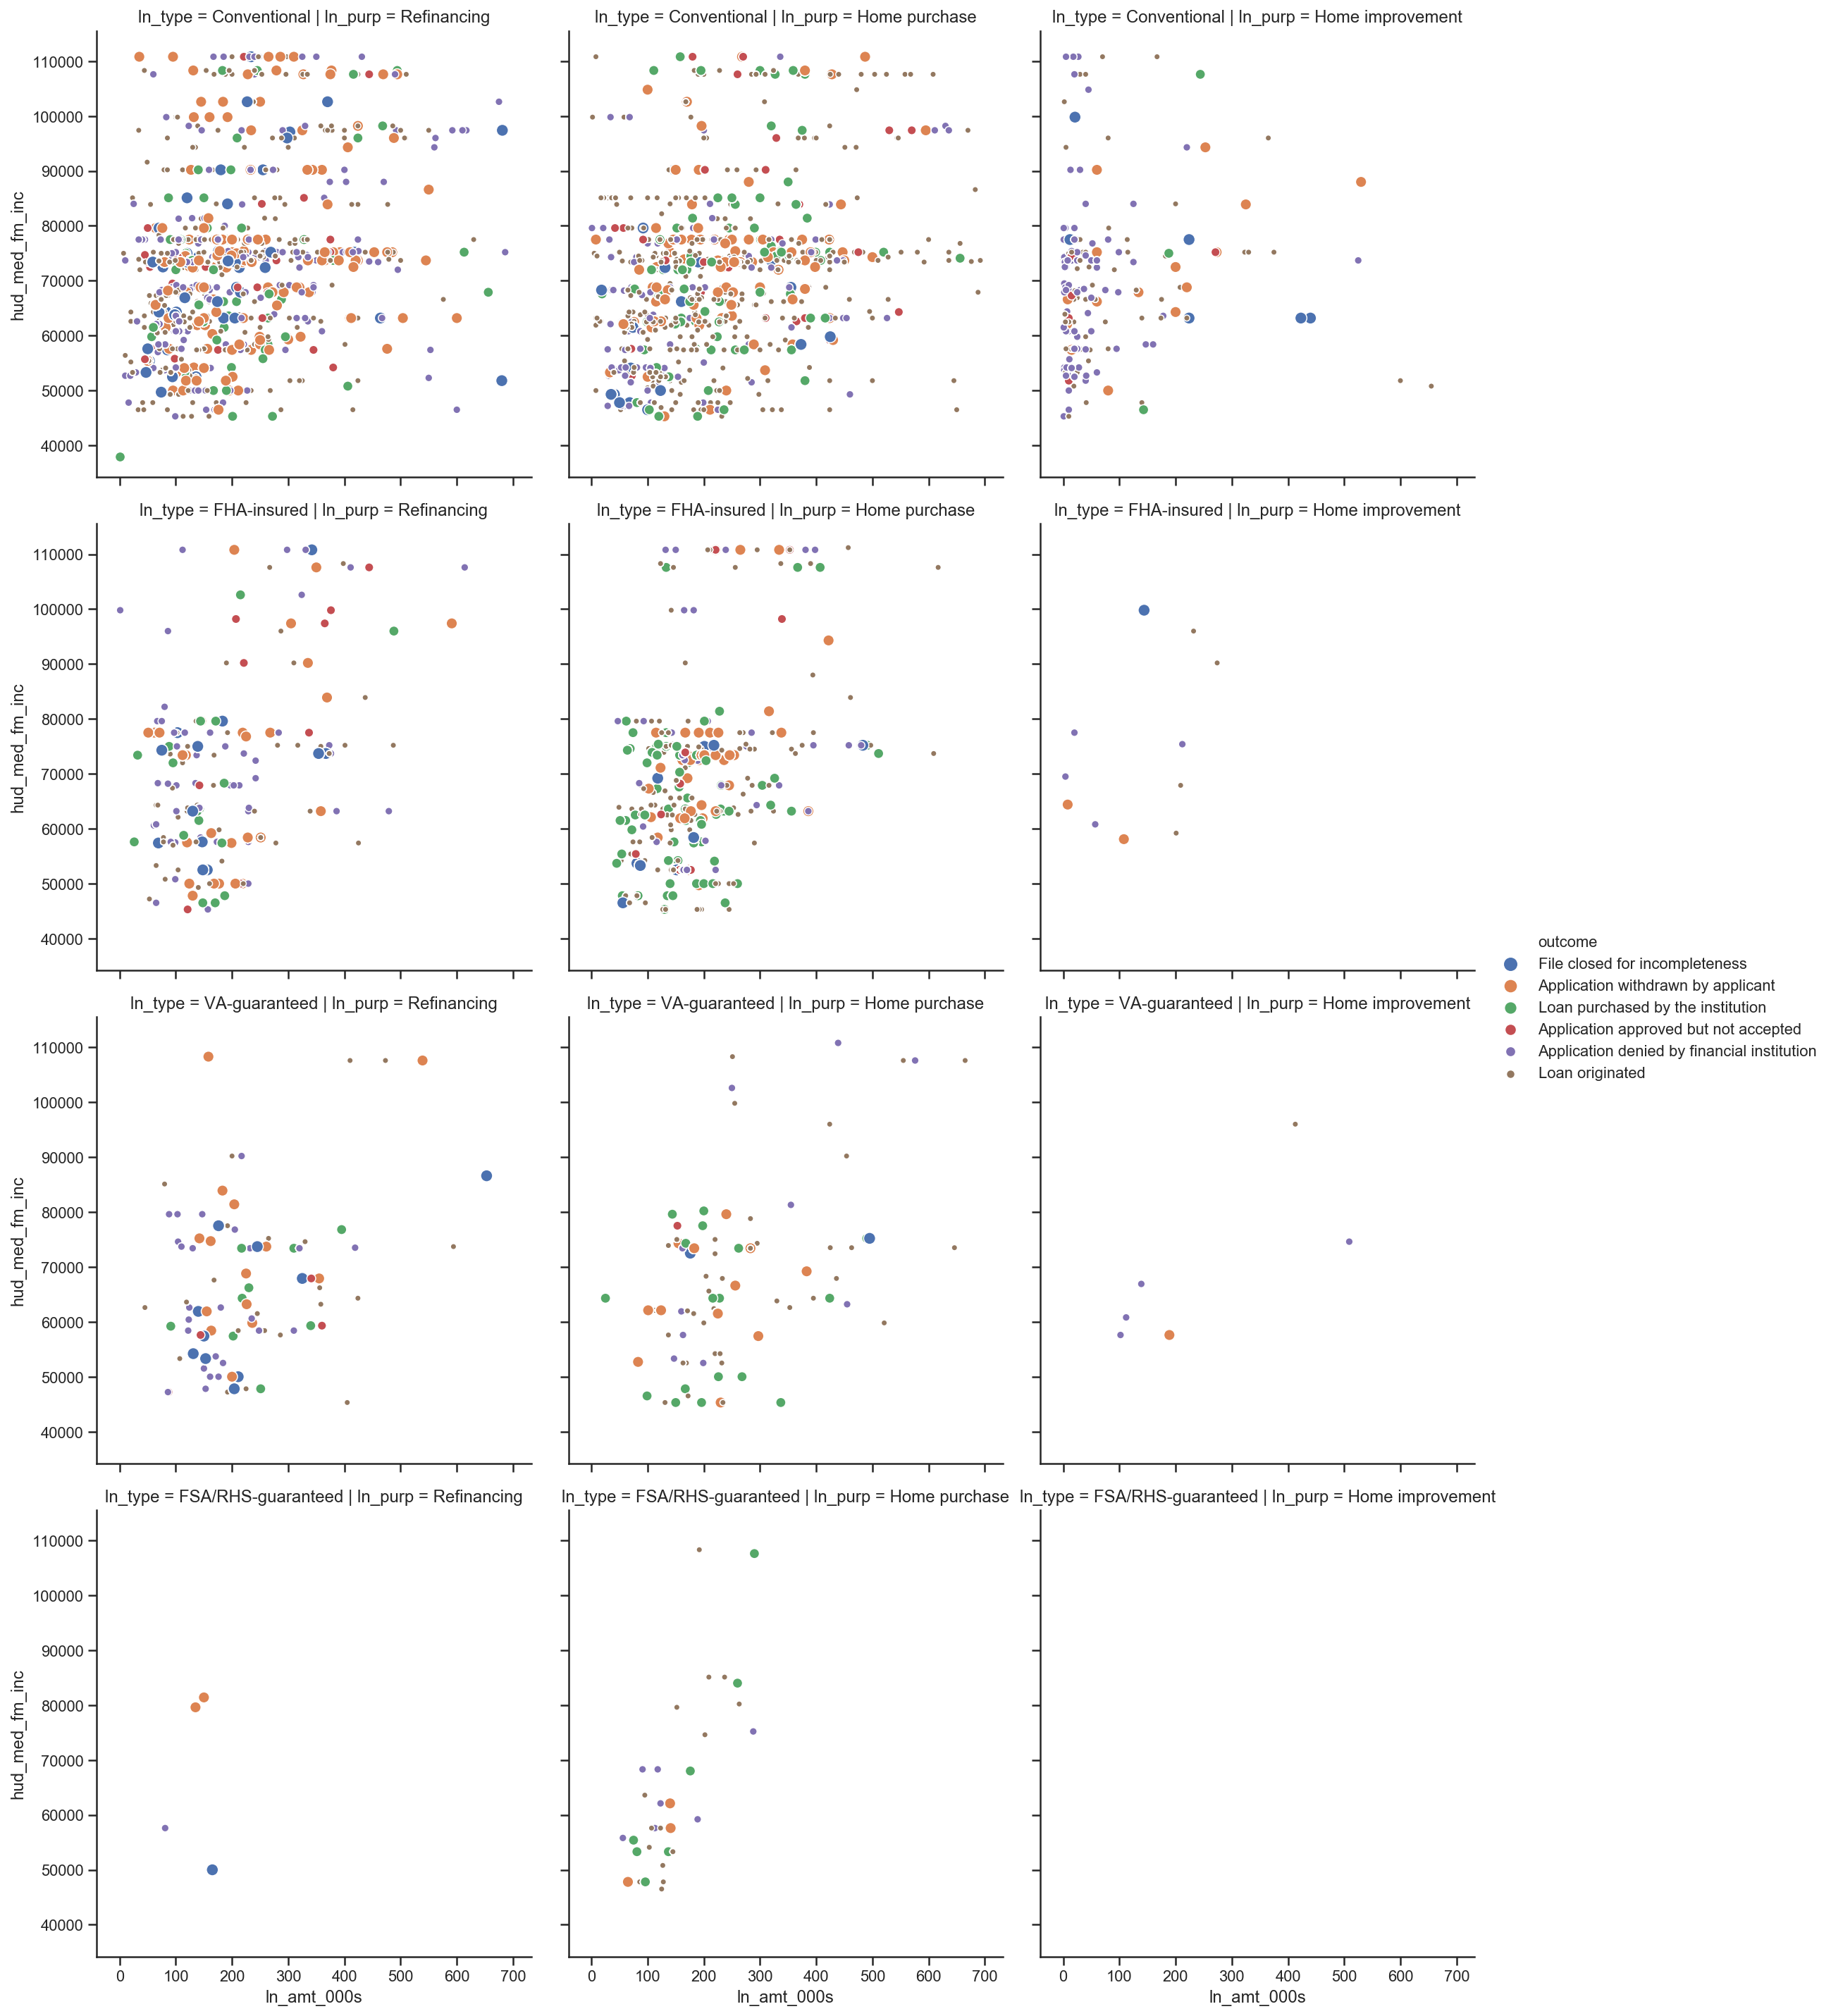

In [168]:
# Grouped by Loan Purpose and Loan Type.

    # --> Drawing scatter plots that facet on columns, and rows, with another variable.
df2 = df[df.ln_amt_000s < 700]
g = sns.relplot(x = 'ln_amt_000s', y = 'hud_med_fm_inc', col = 'ln_purp', 
                hue = 'outcome', size = 'outcome', legend = 'brief', data = df2)
print(' ')
print('Loan Application Outcome: Line Shaded Scatter Plot of Loan Amounts vs. Household Median Income, Grouped by Loan Purpose')

In [ ]:
# Using a differnt kind of plot.

    # --> Drawing line scatter plots -- generating shaded areas of dispersion -- that facet on columns with another variable.
df2 = df[df.ln_amt_000s < 700]
sns.relplot(x = 'ln_amt_000s', y = 'hud_med_fm_inc', col = 'ln_purp', 
            hue = 'outcome', size = 'outcome', row = 'ln_type', legend = 'brief', data = df2)
print(' ')
print('Loan Application Outcome: Scatter Plot of Loan Amounts vs. Household Median Income, Grouped by Loan Purpose and Loan Type')